1 - Le problème : Une banque à besoin de connaitre est-ce que cette personne X, nous allons lui accorder un crédit ou non ? 

In [35]:
# importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [36]:
df=pd.read_csv('train_u6lujuX_CVtuZ9i.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [37]:
# voir les valeurs manquantes
df.info()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [38]:
# voir les valeurs anormales et outliers avec min et max (Uniquement pour les variables numérique)
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [39]:
# vérifier les valeurs de type objet / texte / non numérique
df.describe(include='O')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


Plusieurs méthode, on peux les supprimer si peu de valeurs, ou alors y mettre des valeurs médianne ou moyenne ou mode Dans ce cas, dés que nous avons une valeur manquante. Nous allons la remplacer par une la valeur du dessus. Pour se faire nous allons divisé la base de données en deux : Un df variable numérique (num_data)et un df variable catégorique (cat_data)

In [40]:
cat_data=[]                                 # liste pour stocker les colonnes catégorielle (de type 'object)
num_data=[]                                 # liste pour sotkcer les collones numériques
for i,c in enumerate(df.dtypes):            # boucle sur chaque colonne avec son indice et son type de données
  if c==object:                             # si le type de données de la colonne est'object
    cat_data.append(df.iloc[:,i])           # alors ajouter la colonne à la liste cat_data
  else:                                     # sinon
    num_data.append(df.iloc[:,i])           # ajouter la colonne a la liste num_data

cat_data=pd.DataFrame(cat_data).transpose() # transformation de la liste cat en dataframe, puis transposition
num_data=pd.DataFrame(num_data).transpose() # transformation de la liste num en dataframe, puis transposition


Pour les variables catégoriques, je vais remplacer la valeurs manquantes par la valeurs qui revient le plus dans cette colonne. Afin d'aller dans le sens de l'échantillonage

In [41]:
cat_data=cat_data.apply(lambda x:x.fillna(x.value_counts().index[0])) # apply une fonction dans chaque colonne pour compter la valeurs qui revient le plus et la remplacer pour les NaN
cat_data.isnull().sum().any()  # vérification qu'il n'y a plus de valeur manquante                                       

False

Pour les variables numériques, je voulais remplacer les valeurs manquantes par la valeurs précédente mais je préfère finalement prendre la valeurs médianne car je me dis que cela est surement plus logique. 

In [42]:
num_data=num_data.apply(lambda x: x.fillna(x.median())) 
num_data.isnull().sum().any()

False

Je vais changer le statut des ligne de la colonne 'Loan_Status' pour passer de valeur Y=1 et N=0. 

In [43]:
target_value={'Y':1, 'N':0}                           # Création d'un dictionnaire ou Y mappé à 1 et N mappé à 0
target=cat_data['Loan_Status']                        # Target stocke la colonne Loean Status de cat_data. 
cat_data.drop('Loan_Status', axis=1, inplace=True)    # Supprimé la colonne avec Loan_Status, axis 1 pour toute la colonne, et inplace=true  pour supprimer sans créer un nouveau df
target=target.map(target_value)                       # Convertir les valeurs Y et N en 1 et 0 respectivement. 
target

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

On supprime la colonne Loan_Status car c'est notre target, c'est que nous essaierons de prédire. C'est notre variable cible pour le problème de Machine Learning. On souhaite donc qu'elle ne soit plus présente car elle ne fait pas partie des features d'entrée de notre modèle.  

On a donc fait cette conversion à la main pour la target. mais pour les autres features nous allons le faire automatique via skklearn label encoder. Cela va nous permettre de remplacer les valeurs catégorique par des valeurs numériques. 

In [44]:
le=LabelEncoder()                               # initialisation du LabelEncoder
for i in cat_data:                              # boucle sur chaque colonne de cat_data
  cat_data[i]=le.fit_transform(cat_data[i])     # encodage des valeurs catégorielle

cat_data                                        # print the result of loop

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,0,1,0,0,0,0,2
1,1,1,1,1,0,0,0
2,2,1,1,0,0,1,2
3,3,1,1,0,1,0,2
4,4,1,0,0,0,0,2
...,...,...,...,...,...,...,...
609,609,0,0,0,0,0,0
610,610,1,1,3,0,0,0
611,611,1,1,1,0,0,2
612,612,1,1,2,0,0,2


In [45]:
# delete loan_id
cat_data.drop('Loan_ID', axis=1, inplace=True)

Maintenant je vais concatenner les variables anciennement catégorique avec les variables numérique en un seul dataframe et spécifier la colonne target. X et Y.  

  - X sera pour les données indépendante, c'est à dire que l'on va utiliser pour résoudre la problématique (donner le crédit ou non)

  - Y sera la variable dépendante, donc la réponse finalement

In [46]:
X=pd.concat([cat_data,num_data],axis=1)
Y=target

In [47]:
# Ce qui va nous permettre de résoudre le problème
X

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1,0,0,0,0,2,5849.0,0.0,128.0,360.0,1.0
1,1,1,1,0,0,0,4583.0,1508.0,128.0,360.0,1.0
2,1,1,0,0,1,2,3000.0,0.0,66.0,360.0,1.0
3,1,1,0,1,0,2,2583.0,2358.0,120.0,360.0,1.0
4,1,0,0,0,0,2,6000.0,0.0,141.0,360.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,0,2900.0,0.0,71.0,360.0,1.0
610,1,1,3,0,0,0,4106.0,0.0,40.0,180.0,1.0
611,1,1,1,0,0,2,8072.0,240.0,253.0,360.0,1.0
612,1,1,2,0,0,2,7583.0,0.0,187.0,360.0,1.0


In [48]:
# La réponse au problème
Y

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

----------------------------------------------------------

ANALYSE EXPLORATOIRE

---------------------------------------------------------

In [49]:
# la base de données utilisée pour l'analyse exploratoire. Pour pouvoir mesurer l'impact des variable on a besoin de remettre le résultat
df=pd.concat([cat_data, num_data,target], axis=1)

In [50]:
yes=target.value_counts()[0]/len(target)
no=target.value_counts()[1]/len(target)
print(f'la proportion des crédits accordés est:{yes}')
print(f'la proportion des crédits refusés est:{no}')

la proportion des crédits accordés est:0.3127035830618892
la proportion des crédits refusés est:0.6872964169381107


Je vais essayer l'impact de chaque variable sur le fait d'avoir un crédit ou pas

c:\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


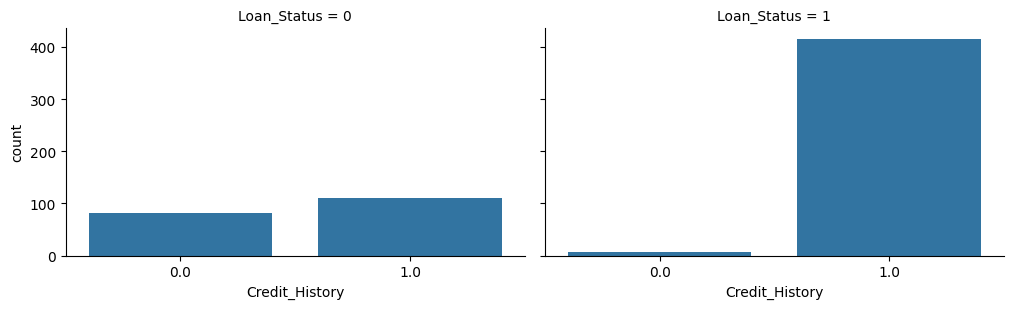

In [51]:
# Historique de crédit 
grid=sns.FacetGrid(df,col='Loan_Status', height=3.2, aspect=1.6)
grid.map(sns.countplot, 'Credit_History')

La figure de droite, c'est les crédit accepté car 1 = Yes. On voit que les personnes qui ont déjà un historique de crédit sont plus accepté. E tles gens qui n'avais pas d'historique de crédit avait peu de crédit accordé. 

Pour la figure de gauche, ce sont les crédit refusé. On voit que l'historique a peu d'importance. On retiens donc que si on a un crédit, on a bcp plus de chance d'en avoir un autre accordé ce qui es peu logique selon moi.  

c:\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


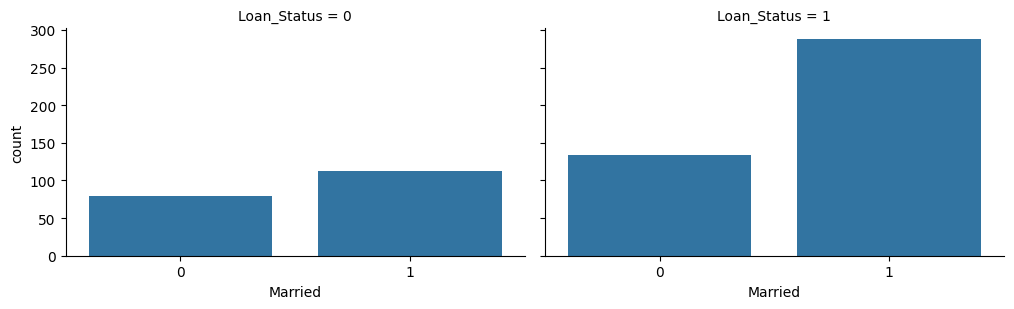

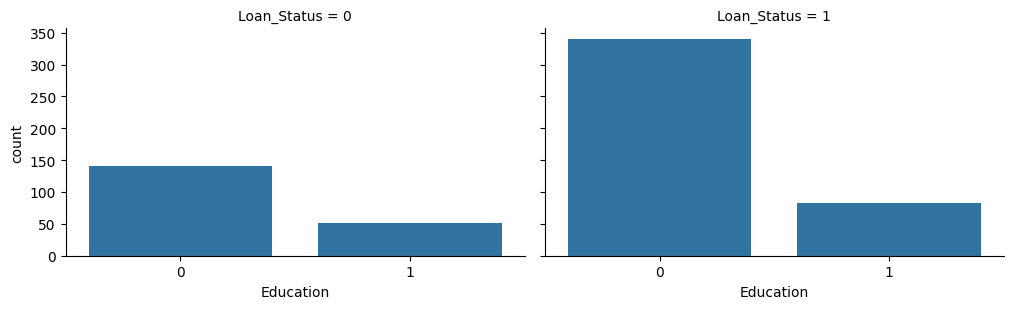

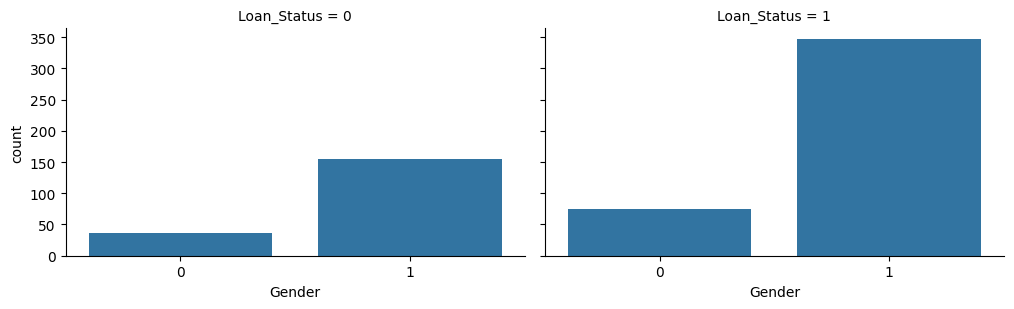

In [52]:
# Married
grid=sns.FacetGrid(df,col='Loan_Status', height=3.2, aspect=1.6)
grid.map(sns.countplot, 'Married')

 # Education
grid=sns.FacetGrid(df,col='Loan_Status', height=3.2, aspect=1.6)
grid.map(sns.countplot, 'Education')

# Gender
grid=sns.FacetGrid(df,col='Loan_Status', height=3.2, aspect=1.6)
grid.map(sns.countplot, 'Gender')

Maintenant nous allons faire cela avec une variable numérique. Le salaire par exemple. On va faire ça via une nuage de point (scatter) pour voir la relatione entre les deux. 

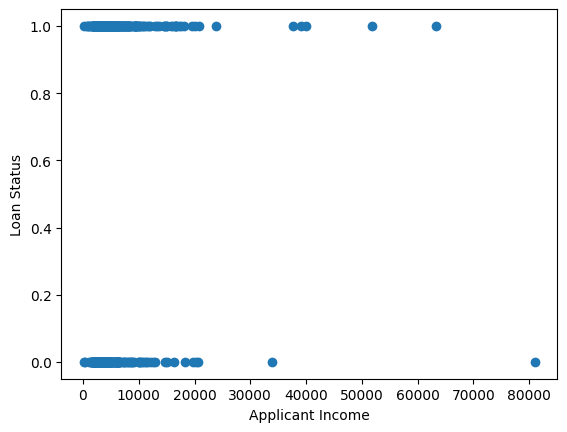

In [53]:
plt.scatter(df['ApplicantIncome'], df['Loan_Status'])  # Specify both x and y arguments
plt.xlabel('Applicant Income')
plt.ylabel('Loan Status')
plt.show()

In [54]:
df.groupby('Loan_Status').median()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,,,,,,
0,1.0,1.0,0.0,0.0,0.0,1.0,3833.5,268.0,128.0,360.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,3812.5,1239.5,128.0,360.0,1.0


-----------------------------------------------------------

Réalisation d'un modèle de machine Learning

-----------------------------------------------------------

On vient diviser notre base de donnée en une base de données test et une autre base de données entrainement. 
Dans notre base de donnée entrainement : on va prendres des profils qui ont eu un crédit et qui n'ont pas eu de crédit en respecant a peu près les même proportion entre les données test et entrainement. 

In [55]:
sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # utilisée pour effectuer  une division des données tout en présevant la proportion de chaque classe ( variable cible) dans les jeux d'entrainement et de tst

for train,test in sss.split(X,Y):
  X_train,X_test=X.iloc[train],X.iloc[test] # X_train et X_test cntiennent respectivement les données d'entrainement et de  des varibale indépendants
  Y_train,Y_test=Y.iloc[train],Y.iloc[test] # Yètrain et y_test contiennent respectivement les données de train et test pour la variable cible. 

print('X train taille : ', X_train.shape)
print('X test taille : ', X_test.shape)
print('Y train taille : ', Y_train.shape)
print('Y test taille : ', Y_test.shape)

X train taille :  (491, 11)
X test taille :  (123, 11)
Y train taille :  (491,)
Y test taille :  (123,)


On va tester avec trois modèle de machine learning. Afin de choisir le meilleuir pour ce cas précis. On va donc appliquer : 

- Logistic Regression
- KNN
- DecisionTree

In [56]:
models={
  'LogisticRegression': LogisticRegression(random_state=200),
  'KNeighborsClassifier': KNeighborsClassifier(),
  'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=1, random_state=42)

}

# Je vais définir la fonction de précision, on va prendre le accuracy score qui va comparer les valeurs prédite avec les valeurs réels. 

def accu(y_true,y_pred,retu=False):
  acc=accuracy_score(y_true, y_pred)
  if retu:
    return acc 
  else:
    print(f' la précision du modèle est :{acc}')

# la fonction qui permets l'application des modèles
def train_test_eval(models, X_train, Y_train, X_test, Y_test):
  for name, models in models.items():
    print(name,':')
    models.fit(X_train,Y_train)
    accu(Y_test,models.predict(X_test))
    print('-'*30)

train_test_eval(models, X_train, Y_train, X_test,Y_test)



LogisticRegression :
 la précision du modèle est :0.8617886178861789
------------------------------
KNeighborsClassifier :
 la précision du modèle est :0.6504065040650406
------------------------------
DecisionTreeClassifier :
 la précision du modèle est :0.8536585365853658
------------------------------


c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
X_2=X[['Credit_History','Married','Education','CoapplicantIncome','ApplicantIncome']] # création d'une liste de liste X

In [58]:
sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # utilisée pour effectuer  une division des données tout en présevant la proportion de chaque classe ( variable cible) dans les jeux d'entrainement et de tst

for train,test in sss.split(X_2,Y):
  X_train,X_test=X_2.iloc[train],X_2.iloc[test] # X_train et X_test cntiennent respectivement les données d'entrainement et de  des varibale indépendants
  Y_train,Y_test=Y.iloc[train],Y.iloc[test] # Yètrain et y_test contiennent respectivement les données de train et test pour la variable cible. 

print('X train taille : ', X_train.shape)
print('X test taille : ', X_test.shape)
print('Y train taille : ', Y_train.shape)
print('Y test taille : ', Y_test.shape)

X train taille :  (491, 5)
X test taille :  (123, 5)
Y train taille :  (491,)
Y test taille :  (123,)


In [59]:
train_test_eval(models, X_train, Y_train, X_test,Y_test)

LogisticRegression :
 la précision du modèle est :0.8617886178861789
------------------------------
KNeighborsClassifier :
 la précision du modèle est :0.6585365853658537
------------------------------
DecisionTreeClassifier :
 la précision du modèle est :0.8536585365853658
------------------------------


c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
# Appliquer la regression logistique sur notre base de donnée
Classifier=LogisticRegression(max_iter=200)
Classifier.fit(X_2,Y)

LogisticRegression(max_iter=200)

In [64]:
# Enregistrer le modèle 
pickle.dump(Classifier, open('model.pkl','wb'))